In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
# ✅ Step 1: Imports and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16, EfficientNetB0
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

2025-08-18 18:11:56.772369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755540716.962508      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755540717.016215      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# ✅ Step 2: Load and Preprocess Dataset
def load_data_from_nested_dirs(data_dir):
    images = []
    labels = []
    for split in ['Training', 'Testing']:
        split_dir = os.path.join(data_dir, split)
        if not os.path.exists(split_dir):
            continue
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_path):
                continue
            for img_file in os.listdir(class_path):
                if img_file.endswith(('.jpg', '.jpeg', '.png')):
                    img_path = os.path.join(class_path, img_file)
                    label = class_name.lower().replace('no_tumor', 'notumor').replace('_tumor', '')
                    images.append(img_path)
                    labels.append(label)
    return images, labels

base_dir = "/kaggle/input"
dataset1 = os.path.join(base_dir, "brain-tumor-mri-dataset")
dataset2 = os.path.join(base_dir, "brain-tumor-classification-mri")

images1, labels1 = load_data_from_nested_dirs(dataset1)
images2, labels2 = load_data_from_nested_dirs(dataset2)

images = images1 + images2
labels = labels1 + labels2

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, stratify=labels_encoded, random_state=42)


In [4]:
# ✅ Step 3: Resize and Normalize
IMG_SIZE = (224, 224)

def load_and_resize(img_paths):
    return np.array([cv2.resize(cv2.imread(path), IMG_SIZE) for path in img_paths])

X_train_resized = load_and_resize(X_train)
X_val_resized = load_and_resize(X_val)

y_train_cat = to_categorical(y_train, num_classes=4)
y_val_cat = to_categorical(y_val, num_classes=4)




Total images in merged dataset: 10287
    dataset     split      class      image_name  \
0  dataset1  Training  pituitary  Tr-pi_0532.jpg   
1  dataset1  Training  pituitary  Tr-pi_0282.jpg   
2  dataset1  Training  pituitary  Tr-pi_1401.jpg   
3  dataset1  Training  pituitary  Tr-pi_0914.jpg   
4  dataset1  Training  pituitary  Tr-pi_0691.jpg   

                                                path  width  height mode  
0  /kaggle/input/brain-tumor-mri-dataset/Training...    512     512  RGB  
1  /kaggle/input/brain-tumor-mri-dataset/Training...    512     512  RGB  
2  /kaggle/input/brain-tumor-mri-dataset/Training...    256     256    L  
3  /kaggle/input/brain-tumor-mri-dataset/Training...    512     512    L  
4  /kaggle/input/brain-tumor-mri-dataset/Training...    512     512  RGB  


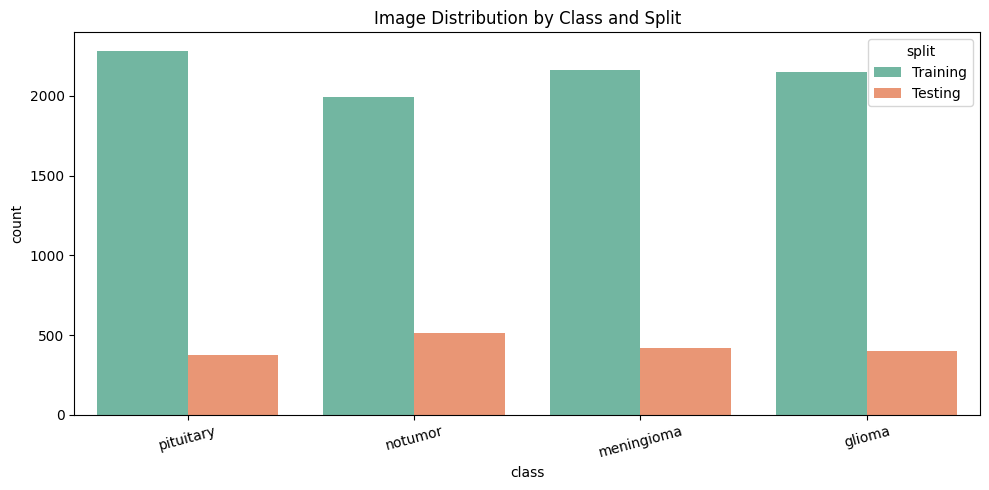

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


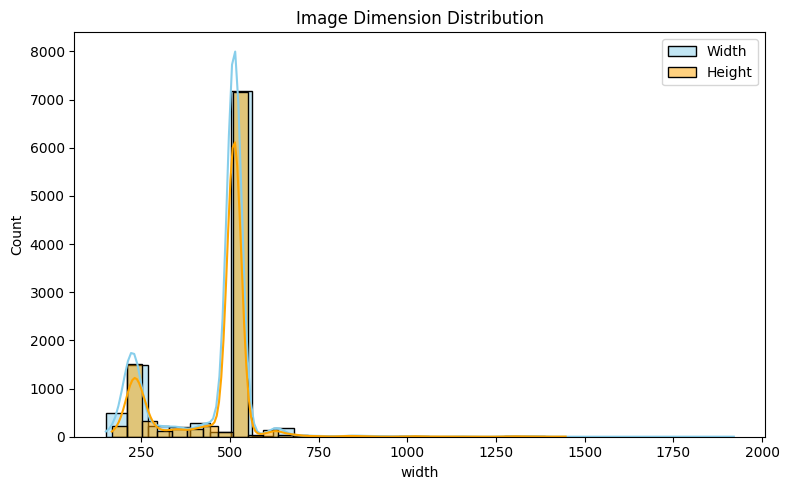

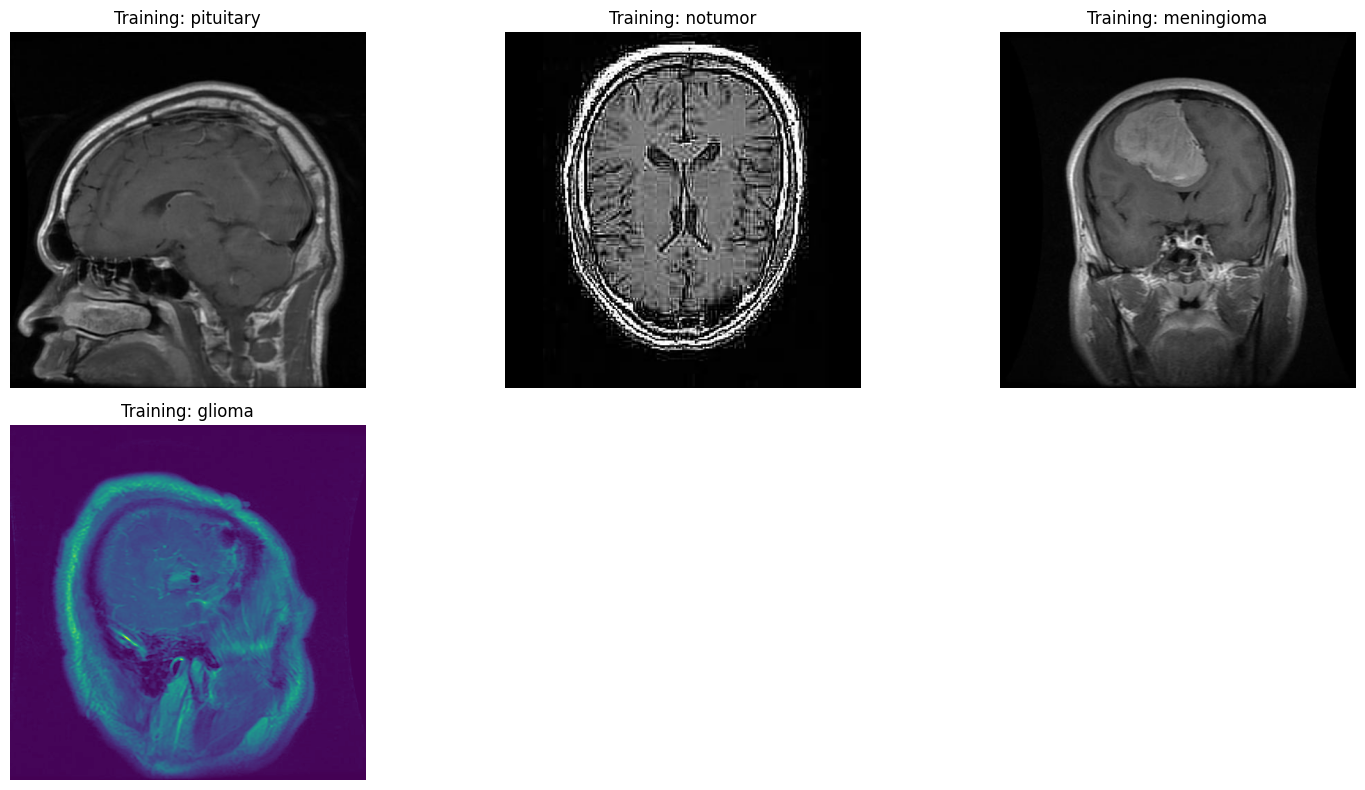

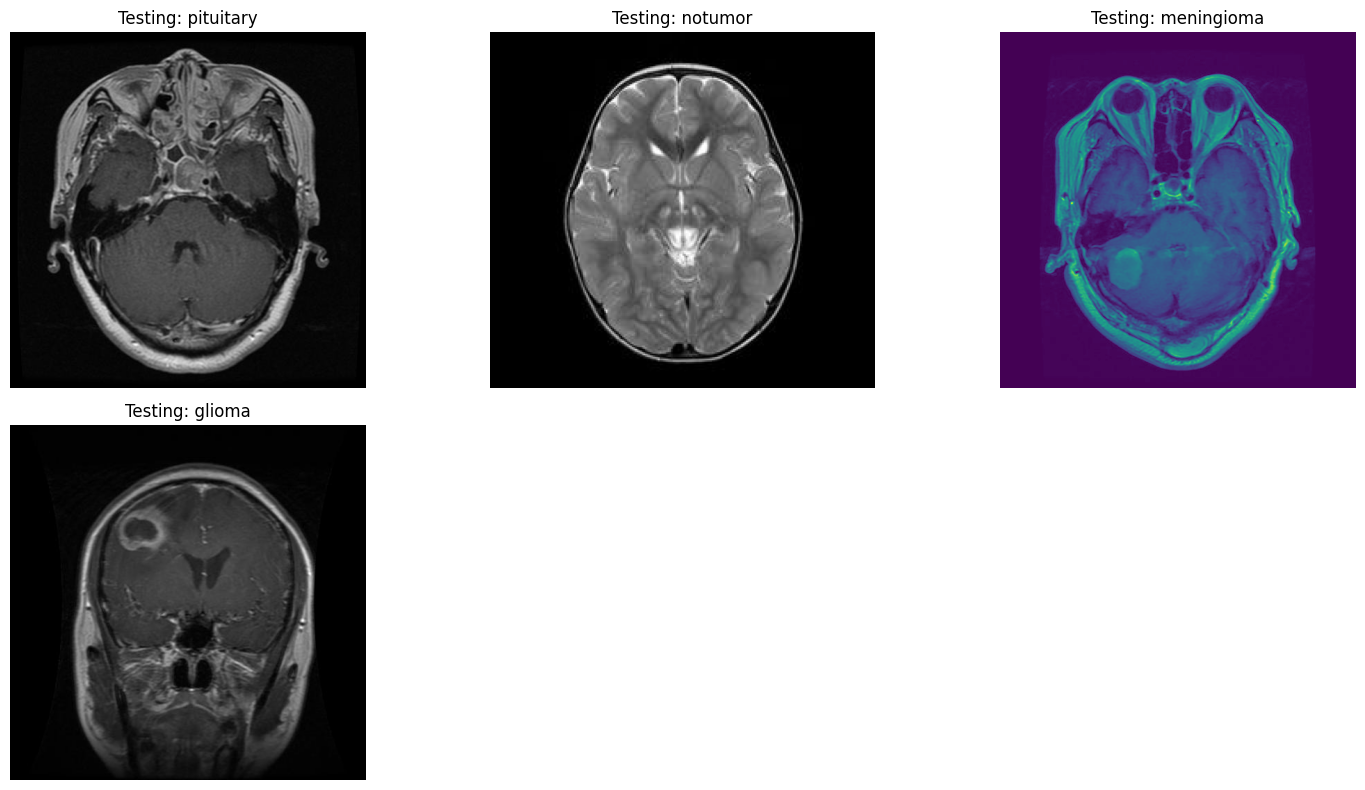

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset paths
dataset1_path = "/kaggle/input/brain-tumor-mri-dataset"
dataset2_path = "/kaggle/input/brain-tumor-classification-mri"

# Class name mapping for standardization
name_map = {
    'glioma_tumor': 'glioma',
    'meningioma_tumor': 'meningioma',
    'pituitary_tumor': 'pituitary',
    'no_tumor': 'notumor',
    'glioma': 'glioma',
    'meningioma': 'meningioma',
    'pituitary': 'pituitary',
    'notumor': 'notumor'
}

# Function to collect metadata from a dataset
def collect_dataset_info(base_path, dataset_name):
    data = []

    for split in ['Training', 'Testing']:
        split_path = os.path.join(base_path, split)
        if not os.path.exists(split_path):
            continue

        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            if not os.path.isdir(class_path):
                continue

            class_name = name_map.get(class_folder, class_folder)

            for img_file in os.listdir(class_path):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img_path = os.path.join(class_path, img_file)
                    try:
                        with Image.open(img_path) as img:
                            width, height = img.size
                            mode = img.mode
                        data.append({
                            'dataset': dataset_name,
                            'split': split,
                            'class': class_name,
                            'image_name': img_file,
                            'path': img_path,
                            'width': width,
                            'height': height,
                            'mode': mode
                        })
                    except Exception as e:
                        print(f"Error reading {img_path}: {e}")
    return pd.DataFrame(data)

# Load metadata from both datasets
df1 = collect_dataset_info(dataset1_path, "dataset1")
df2 = collect_dataset_info(dataset2_path, "dataset2")

# Merge them
df = pd.concat([df1, df2], ignore_index=True)

# ---- EDA Starts ----

print("Total images in merged dataset:", len(df))
print(df.head())

# 📊 Class distribution by split
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='class', hue='split', palette='Set2')
plt.title("Image Distribution by Class and Split")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# 📏 Image size distributions
plt.figure(figsize=(8, 5))
sns.histplot(df['width'], bins=30, color='skyblue', label='Width', kde=True)
sns.histplot(df['height'], bins=30, color='orange', label='Height', kde=True)
plt.legend()
plt.title("Image Dimension Distribution")
plt.tight_layout()
plt.show()

# 🖼️ Show example images
def show_samples(df, split='Training'):
    classes = df['class'].unique()
    plt.figure(figsize=(15, 8))
    for i, cls in enumerate(classes):
        sample = df[(df['class'] == cls) & (df['split'] == split)].iloc[0]
        img = Image.open(sample['path'])
        plt.subplot(2, len(classes)//2 + 1, i+1)
        plt.imshow(img)
        plt.title(f"{split}: {cls}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show sample images
show_samples(df, split='Training')
show_samples(df, split='Testing')


✅ Class-wise Count After Forcing All to 2500:
class
meningioma    2500
notumor       2500
pituitary     2500
glioma        2500
Name: count, dtype: int64


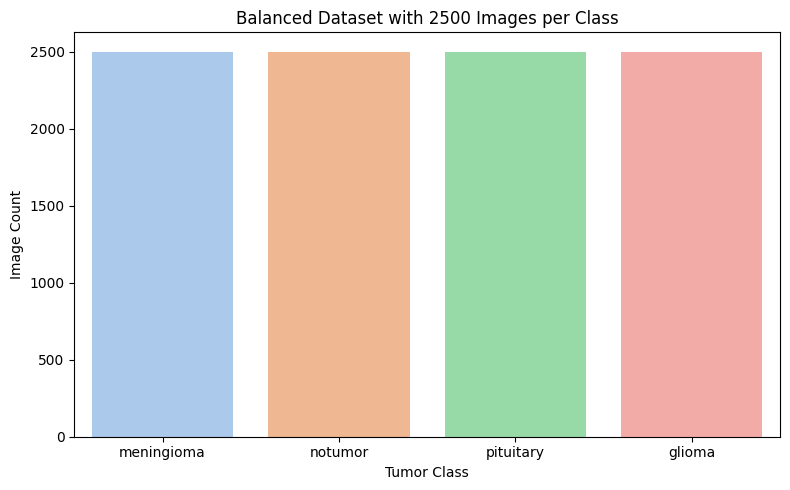

In [6]:
# First, make a copy of the merged dataset
balanced_2500_df = pd.DataFrame()

target_count = 2500

for cls in df['class'].unique():
    class_df = df[df['class'] == cls]
    
    # Downsample to 2500 if necessary
    sampled_df = class_df.sample(n=target_count, random_state=42)
    
    balanced_2500_df = pd.concat([balanced_2500_df, sampled_df], ignore_index=True)

# Shuffle the final DataFrame
balanced_2500_df = balanced_2500_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm the result
print("✅ Class-wise Count After Forcing All to 2500:")
print(balanced_2500_df['class'].value_counts())


plt.figure(figsize=(8, 5))
sns.countplot(data=balanced_2500_df, x='class', palette='pastel')
plt.title("Balanced Dataset with 2500 Images per Class")
plt.xlabel("Tumor Class")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


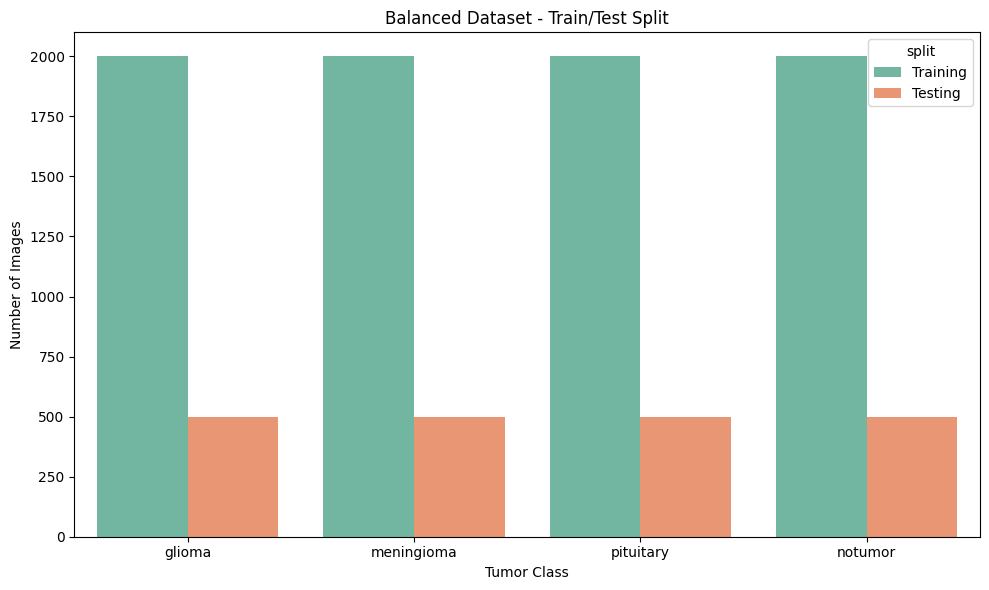

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# Split 2500 images per class into train/test (80/20)
split_balanced = []

# Define the desired class order
class_order = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Ensure consistent lowercase class names
balanced_2500_df['class'] = balanced_2500_df['class'].str.lower()

for cls in class_order:
    class_df = balanced_2500_df[balanced_2500_df['class'] == cls]
    
    train, test = train_test_split(class_df, test_size=0.2, random_state=42, shuffle=True)
    
    train = train.copy()
    test = test.copy()
    train['split'] = 'Training'
    test['split'] = 'Testing'
    
    split_balanced.extend([train, test])

# Merge all splits
split_df = pd.concat(split_balanced, ignore_index=True)

# Convert 'class' column to ordered categorical to control plot order
split_df['class'] = pd.Categorical(split_df['class'], categories=class_order, ordered=True)

# Plot
plt.figure(figsize=(10, 6))
sns.countplot(data=split_df, x='class', hue='split', palette='Set2')

plt.title("Balanced Dataset - Train/Test Split")
plt.xlabel("Tumor Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()


In [8]:
# ✅ Step 4: Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [9]:
'''# Step 5: Data Augmentation
aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.3,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)'''

'''
# ✅ Step 5: Define CNN Architecture (for CustomCNN)
def build_custom_cnn():
    model = Sequential([
        Input(shape=(224, 224, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(),

        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])
    return model


'''
def build_custom_cnn():
    inputs = Input(shape=(224, 224, 3))
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)

    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model



In [10]:
# ✅ Step 6: Build Transfer Learning Wrapper
def build_transfer_model(base, preprocess):
    base_model = base(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(4, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model




I0000 00:00:1755540815.619472      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training CustomCNN...
Epoch 1/50


I0000 00:00:1755540843.746446      64 service.cc:148] XLA service 0x7c6e6c0049c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755540843.747663      64 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755540844.312412      64 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755540850.011951      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/258 - 29s - 112ms/step - accuracy: 0.6902 - loss: 0.8763 - val_accuracy: 0.4723 - val_loss: 3.6592 - learning_rate: 1.0000e-04
Epoch 2/50
258/258 - 9s - 37ms/step - accuracy: 0.7979 - loss: 0.4996 - val_accuracy: 0.8474 - val_loss: 0.4114 - learning_rate: 1.0000e-04
Epoch 3/50
258/258 - 10s - 37ms/step - accuracy: 0.8588 - loss: 0.3643 - val_accuracy: 0.9101 - val_loss: 0.3001 - learning_rate: 1.0000e-04
Epoch 4/50
258/258 - 10s - 37ms/step - accuracy: 0.8901 - loss: 0.2807 - val_accuracy: 0.9325 - val_loss: 0.2030 - learning_rate: 1.0000e-04
Epoch 5/50
258/258 - 9s - 36ms/step - accuracy: 0.9092 - loss: 0.2403 - val_accuracy: 0.9300 - val_loss: 0.2305 - learning_rate: 1.0000e-04
Epoch 6/50
258/258 - 9s - 37ms/step - accuracy: 0.9261 - loss: 0.1887 - val_accuracy: 0.9223 - val_loss: 0.2361 - learning_rate: 1.0000e-04
Epoch 7/50
258/258 - 9s - 37ms/step - accuracy: 0.9361 - loss: 0.1622 - val_accuracy: 0.9490 - val_loss: 0.1914 - learning_rate: 1.0000e-04
Epoch 8/50
258/258 - 9s - 3

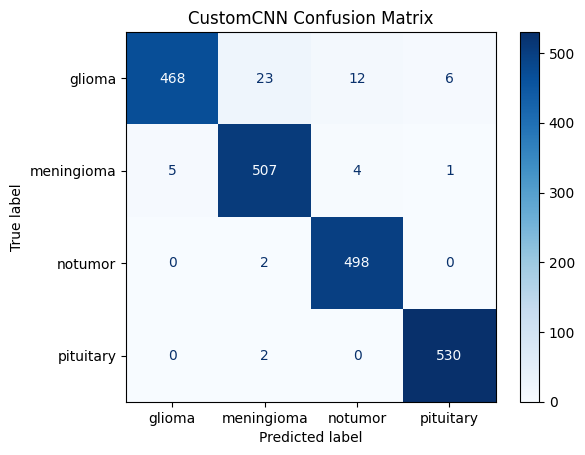


Training MobileNetV2...
Epoch 1/50
258/258 - 32s - 124ms/step - accuracy: 0.6418 - loss: 0.9100 - val_accuracy: 0.8207 - val_loss: 0.5257 - learning_rate: 1.0000e-04
Epoch 2/50
258/258 - 8s - 31ms/step - accuracy: 0.7996 - loss: 0.5379 - val_accuracy: 0.8537 - val_loss: 0.4115 - learning_rate: 1.0000e-04
Epoch 3/50
258/258 - 8s - 31ms/step - accuracy: 0.8400 - loss: 0.4371 - val_accuracy: 0.8858 - val_loss: 0.3559 - learning_rate: 1.0000e-04
Epoch 4/50
258/258 - 8s - 31ms/step - accuracy: 0.8635 - loss: 0.3778 - val_accuracy: 0.8921 - val_loss: 0.3153 - learning_rate: 1.0000e-04
Epoch 5/50
258/258 - 8s - 31ms/step - accuracy: 0.8791 - loss: 0.3355 - val_accuracy: 0.9023 - val_loss: 0.2915 - learning_rate: 1.0000e-04
Epoch 6/50
258/258 - 8s - 31ms/step - accuracy: 0.8921 - loss: 0.3062 - val_accuracy: 0.9023 - val_loss: 0.2740 - learning_rate: 1.0000e-04
Epoch 7/50
258/258 - 8s - 31ms/step - accuracy: 0.9044 - loss: 0.2760 - val_accuracy: 0.9062 - val_loss: 0.2612 - learning_rate: 1.00

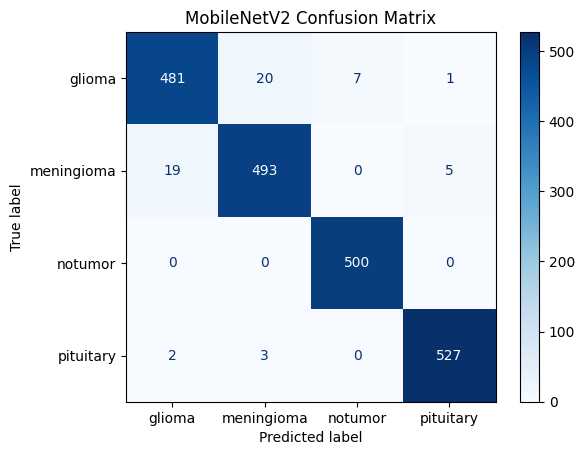


Training VGG16...
Epoch 1/50
258/258 - 43s - 167ms/step - accuracy: 0.4559 - loss: 2.4682 - val_accuracy: 0.7099 - val_loss: 0.7527 - learning_rate: 1.0000e-04
Epoch 2/50
258/258 - 24s - 91ms/step - accuracy: 0.6467 - loss: 0.9711 - val_accuracy: 0.7838 - val_loss: 0.5750 - learning_rate: 1.0000e-04
Epoch 3/50
258/258 - 23s - 91ms/step - accuracy: 0.7183 - loss: 0.7349 - val_accuracy: 0.8231 - val_loss: 0.4913 - learning_rate: 1.0000e-04
Epoch 4/50
258/258 - 23s - 91ms/step - accuracy: 0.7627 - loss: 0.6243 - val_accuracy: 0.8455 - val_loss: 0.4418 - learning_rate: 1.0000e-04
Epoch 5/50
258/258 - 24s - 91ms/step - accuracy: 0.7935 - loss: 0.5479 - val_accuracy: 0.8562 - val_loss: 0.4063 - learning_rate: 1.0000e-04
Epoch 6/50
258/258 - 23s - 91ms/step - accuracy: 0.8164 - loss: 0.4949 - val_accuracy: 0.8664 - val_loss: 0.3695 - learning_rate: 1.0000e-04
Epoch 7/50
258/258 - 23s - 91ms/step - accuracy: 0.8283 - loss: 0.4580 - val_accuracy: 0.8780 - val_loss: 0.3446 - learning_rate: 1.00

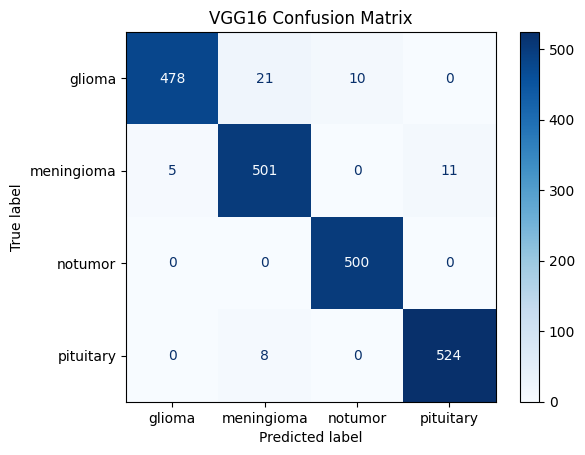


Training EfficientNetB0...
Epoch 1/50
258/258 - 55s - 215ms/step - accuracy: 0.6464 - loss: 0.8827 - val_accuracy: 0.8022 - val_loss: 0.5393 - learning_rate: 1.0000e-04
Epoch 2/50
258/258 - 8s - 32ms/step - accuracy: 0.7958 - loss: 0.5486 - val_accuracy: 0.8455 - val_loss: 0.4202 - learning_rate: 1.0000e-04
Epoch 3/50
258/258 - 8s - 32ms/step - accuracy: 0.8319 - loss: 0.4645 - val_accuracy: 0.8693 - val_loss: 0.3715 - learning_rate: 1.0000e-04
Epoch 4/50
258/258 - 8s - 32ms/step - accuracy: 0.8555 - loss: 0.4071 - val_accuracy: 0.8790 - val_loss: 0.3375 - learning_rate: 1.0000e-04
Epoch 5/50
258/258 - 8s - 32ms/step - accuracy: 0.8635 - loss: 0.3778 - val_accuracy: 0.8878 - val_loss: 0.3284 - learning_rate: 1.0000e-04
Epoch 6/50
258/258 - 8s - 32ms/step - accuracy: 0.8751 - loss: 0.3509 - val_accuracy: 0.8946 - val_loss: 0.2986 - learning_rate: 1.0000e-04
Epoch 7/50
258/258 - 8s - 32ms/step - accuracy: 0.8832 - loss: 0.3256 - val_accuracy: 0.9004 - val_loss: 0.2816 - learning_rate: 1

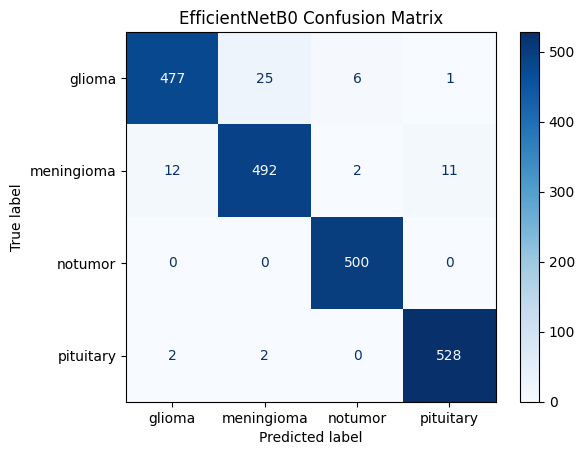

In [11]:
# ✅ Step 7: Train All Models
models = {
    "CustomCNN": build_custom_cnn(),
    "MobileNetV2": build_transfer_model(MobileNetV2, mobilenet_preprocess),
    "VGG16": build_transfer_model(VGG16, vgg16_preprocess),
    "EfficientNetB0": build_transfer_model(EfficientNetB0, efficientnet_preprocess)
}

histories = {}
model_preds = {}
model_scores = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    if name == "CustomCNN":
        X_train_input = X_train_resized / 255.
        X_val_input = X_val_resized / 255.
    elif name == "MobileNetV2":
        X_train_input = mobilenet_preprocess(X_train_resized.copy())
        X_val_input = mobilenet_preprocess(X_val_resized.copy())
    elif name == "VGG16":
        X_train_input = vgg16_preprocess(X_train_resized.copy())
        X_val_input = vgg16_preprocess(X_val_resized.copy())
    elif name == "EfficientNetB0":
        X_train_input = efficientnet_preprocess(X_train_resized.copy())
        X_val_input = efficientnet_preprocess(X_val_resized.copy())

    history = model.fit(
        X_train_input, y_train_cat,
        validation_data=(X_val_input, y_val_cat),
        epochs=50,
        batch_size=32,
        class_weight=class_weights_dict,
        callbacks=[EarlyStopping(patience=9, restore_best_weights=True), ReduceLROnPlateau(patience=5)],
        verbose=2
    )
    histories[name] = history

    y_pred = model.predict(X_val_input)
    y_pred_classes = np.argmax(y_pred, axis=1)
    acc = np.mean(y_pred_classes == y_val)
    model_preds[name] = y_pred
    model_scores[name] = acc

    print(f"\n{name} Accuracy: {acc * 100:.2f}%")
    print(classification_report(y_val, y_pred_classes, target_names=le.classes_))
    cm = confusion_matrix(y_val, y_pred_classes)
    ConfusionMatrixDisplay(cm, display_labels=le.classes_).plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.show()




📌 Ensemble Accuracy: 98.79%
              precision    recall  f1-score   support

      glioma       0.99      0.96      0.98       509
  meningioma       0.98      0.99      0.98       517
     notumor       0.98      1.00      0.99       500
   pituitary       1.00      1.00      1.00       532

    accuracy                           0.99      2058
   macro avg       0.99      0.99      0.99      2058
weighted avg       0.99      0.99      0.99      2058



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


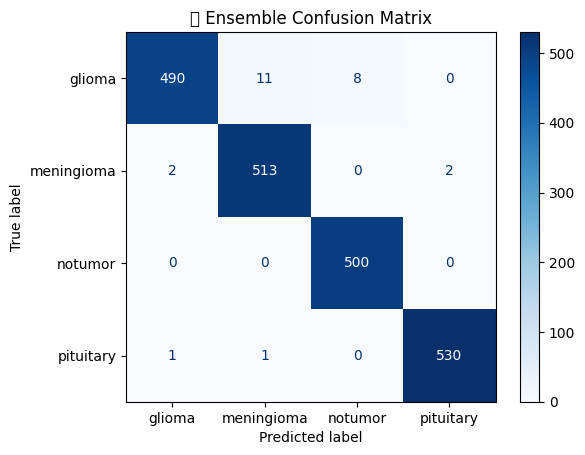

In [12]:
'''# Step 8: Plot Accuracy and Loss

def plot_model_performance(histories):
    plt.figure(figsize=(18, 8))

    # Accuracy
    plt.subplot(1, 2, 1)
    for name, hist in histories.items():
        plt.plot(hist.history['val_accuracy'], label=name)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    for name, hist in histories.items():
        plt.plot(hist.history['val_loss'], label=name)
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_model_performance(histories)'''




# ✅ Step 8: Ensemble Prediction (Soft Voting)
all_preds = np.mean(list(model_preds.values()), axis=0)
y_ensemble = np.argmax(all_preds, axis=1)
ensemble_acc = np.mean(y_ensemble == y_val)
print(f"\n📌 Ensemble Accuracy: {ensemble_acc * 100:.2f}%")
print(classification_report(y_val, y_ensemble, target_names=le.classes_))
cm_ensemble = confusion_matrix(y_val, y_ensemble)
ConfusionMatrixDisplay(cm_ensemble, display_labels=le.classes_).plot(cmap='Blues')
plt.title("🧠 Ensemble Confusion Matrix")
plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
🔍 Generating Grad-CAM for CustomCNN...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
🔍 Generating Grad-CAM for MobileNetV2...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
🔍 Generating Grad-CAM for VGG16...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 943ms/step
🔍 Generating Grad-CAM for EfficientNetB0...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


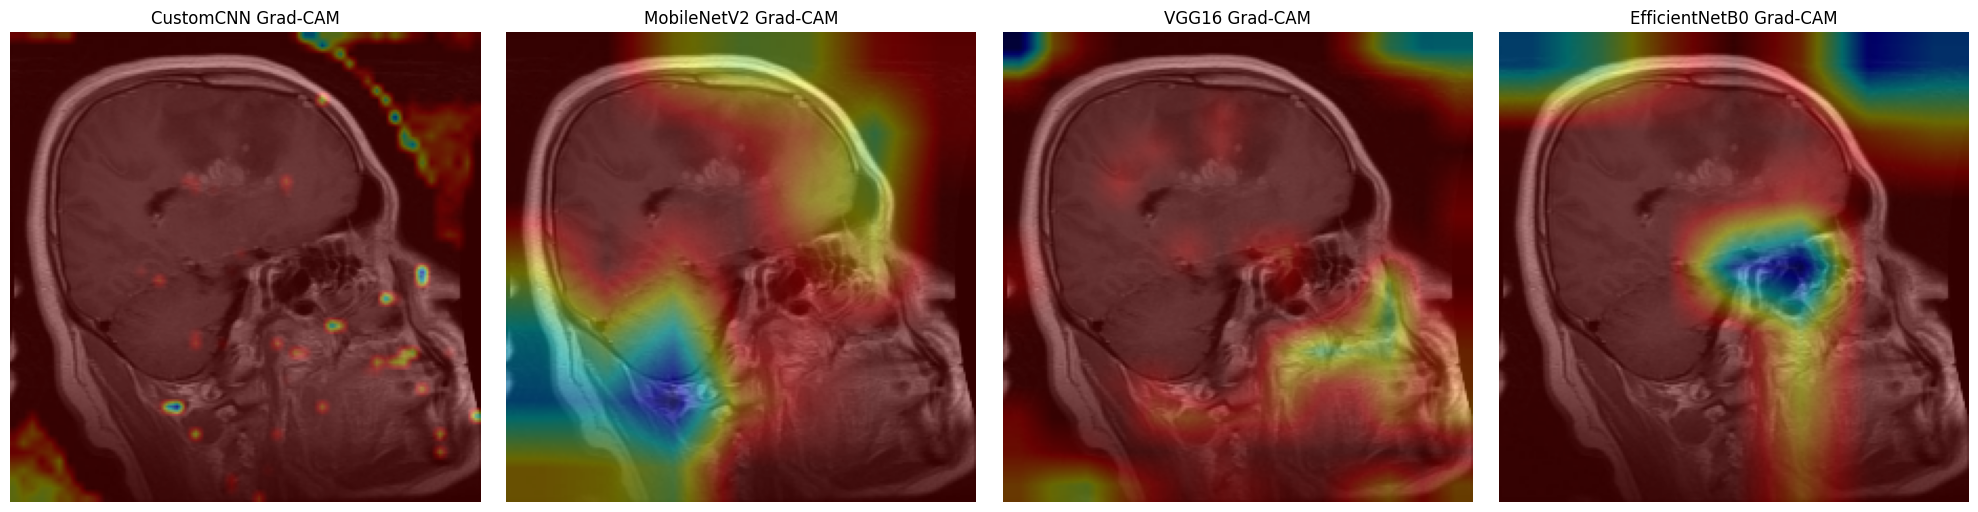

In [13]:
'''# Step 9: Model Ensemble (Soft Voting)
all_preds = np.mean(list(model_preds.values()), axis=0)
y_ensemble = np.argmax(all_preds, axis=1)
ensemble_acc = np.mean(y_ensemble == y_val)
print(f"\nEnsemble Accuracy: {ensemble_acc * 100:.2f}%")
print(classification_report(y_val, y_ensemble, target_names=le.classes_))
cm_ensemble = confusion_matrix(y_val, y_ensemble)
ConfusionMatrixDisplay(cm_ensemble, display_labels=le.classes_).plot(cmap='Blues')
plt.title("Ensemble Confusion Matrix")
plt.show()'''



'''
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model

# ✅ Robust Grad-CAM Generator
def generate_grad_cam(model, image, label_index, preprocess=None, model_name="CustomCNN"):
    # Preprocess the image
    img_tensor = np.expand_dims(image, axis=0)
    if preprocess:
        img_tensor = preprocess(img_tensor.copy())
    else:
        img_tensor = img_tensor / 255.0

    # 🔧 Force model to build if it's Sequential (CustomCNN)
    _ = model.predict(img_tensor)

    # 🧠 Identify the last Conv2D layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer.name
            break

    if not last_conv_layer:
        raise ValueError(f"No Conv2D layer found in model {model_name}")

    # 🎯 Build gradient model
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer).output, model.output]
    )

    # 📈 Compute gradient
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, label_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(image.astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)
    return superimposed_img

# ✅ Sample image and label
sample_img = X_val_resized[0]
true_label = y_val[0]

# ✅ Preprocessors for each model
preprocessors = {
    "CustomCNN": None,
    "MobileNetV2": mobilenet_preprocess,
    "VGG16": vgg16_preprocess,
    "EfficientNetB0": efficientnet_preprocess
}

# ✅ Plot Grad-CAM for all models
plt.figure(figsize=(20, 5))
for i, (name, model) in enumerate(models.items()):
    print(f"🔍 Generating Grad-CAM for {name}...")
    try:
        cam_img = generate_grad_cam(model, sample_img, true_label, preprocess=preprocessors[name], model_name=name)
        plt.subplot(1, 4, i + 1)
        plt.imshow(cam_img)
        plt.title(f"{name} Grad-CAM")
        plt.axis('off')
    except Exception as e:
        print(f"❌ Failed for {name}: {e}")

plt.tight_layout()
plt.show()
'''


# ✅ Step 9: Grad-CAM Visualization for All Models (Kaggle-compatible)
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Patch CustomCNN so it's 'called'
_ = models["CustomCNN"].predict(np.expand_dims(X_val_resized[0] / 255., axis=0))


# ✅ Grad-CAM Generator Function (Robust for all models)
def generate_grad_cam(model, image, label_index, preprocess=None, model_name="Model"):
    # Preprocess image
    img_tensor = np.expand_dims(image, axis=0)
    if preprocess:
        img_tensor = preprocess(img_tensor.copy())
    else:
        img_tensor = img_tensor / 255.0

    # 🛠 Build/Call Sequential models manually to fix the "never been called" error
    try:
        _ = model.predict(img_tensor)
    except:
        model.build((None, 224, 224, 3))
        _ = model.predict(img_tensor)

    # 🔍 Find last Conv2D layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer.name
            break
    if not last_conv_layer:
        raise ValueError(f"No Conv2D layer found in model {model_name}")

    # 🎯 Build Grad-CAM model
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer).output, model.output]
    )

    # 🔥 Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, label_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + tf.keras.backend.epsilon())
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(image.astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)
    return superimposed_img

# ✅ Preprocessing for each model
preprocessors = {
    "CustomCNN": None,
    "MobileNetV2": mobilenet_preprocess,
    "VGG16": vgg16_preprocess,
    "EfficientNetB0": efficientnet_preprocess,
    
}

# ✅ Sample image from validation set
sample_img = X_val_resized[0]
true_label = y_val[0]

# 🔥 Generate Grad-CAM visualizations
plt.figure(figsize=(20, 5))
for i, (name, model) in enumerate(models.items()):
    print(f"🔍 Generating Grad-CAM for {name}...")
    try:
        cam_img = generate_grad_cam(model, sample_img, true_label, preprocess=preprocessors[name], model_name=name)
        plt.subplot(1, 4, i + 1)
        plt.imshow(cam_img)
        plt.title(f"{name} Grad-CAM")
        plt.axis('off')
    except Exception as e:
        print(f"❌ Failed for {name}: {e}")

plt.tight_layout()
plt.show()


In [14]:
'''# Step 10: Save Best Model
from sklearn.metrics import accuracy_score

# Check if models exist
try:
    models
except NameError:
    raise ValueError("❌ 'models' is not defined. Please run Step 7 before executing Step 10.")

model_scores = {}
model_preds = {}

for name, model in models.items():
    # Use appropriate preprocessing
    if name == "CustomCNN":
        X_val_input = X_val_resized / 255.
    elif name == "MobileNetV2":
        X_val_input = mobilenet_preprocess(X_val_resized.copy())
    elif name == "VGG16":
        X_val_input = vgg16_preprocess(X_val_resized.copy())
    elif name == "EfficientNetB0":
        X_val_input = efficientnet_preprocess(X_val_resized.copy())
    
    # Predict and score
    y_pred = model.predict(X_val_input)
    y_pred_classes = np.argmax(y_pred, axis=1)
    acc = accuracy_score(y_val, y_pred_classes)
    model_scores[name] = acc
    model_preds[name] = y_pred

# Save best model
best_model_name = max(model_scores, key=model_scores.get)
print(f"\n✅ Best performing model: {best_model_name} with accuracy {model_scores[best_model_name]*100:.2f}%")
models[best_model_name].save(f"best_model_{best_model_name}.h5")'''



# ✅ Step 10: Save Best Model
best_model_name = max(model_scores, key=model_scores.get)
print(f"\n✅ Best Performing Model: {best_model_name} with Accuracy: {model_scores[best_model_name] * 100:.2f}%")
models[best_model_name].save(f"best_model_{best_model_name}.h5")



✅ Best Performing Model: CustomCNN with Accuracy: 97.33%


In [15]:
'''# Step 11: Display All Model Accuracies
import numpy as np

if not model_preds:
    raise ValueError("❌ model_preds is empty. Please rerun Step 7 to generate predictions.")

# Safely compute ensemble accuracy
try:
    all_preds = np.mean(list(model_preds.values()), axis=0)
    y_ensemble = np.argmax(all_preds, axis=1)
    ensemble_acc = np.mean(y_ensemble == y_val)
except Exception as e:
    raise RuntimeError(f"❌ Failed to compute ensemble accuracy: {e}")

# Compute model_scores if missing
if 'model_scores' not in globals():
    model_scores = {name: np.mean(np.argmax(preds, axis=1) == y_val) for name, preds in model_preds.items()}

# Print all accuracies
print("\n📊 All Model Accuracies:")
for model_name, score in model_scores.items():
    print(f"{model_name}: {score * 100:.2f}%")
print(f"Ensemble: {ensemble_acc * 100:.2f}%")'''




# ✅ Step 11: Display All Accuracies
print("\n📊 All Model Accuracies:")
for model_name, score in model_scores.items():
    print(f"{model_name}: {score * 100:.2f}%")
print(f"Ensemble: {ensemble_acc * 100:.2f}%")



📊 All Model Accuracies:
CustomCNN: 97.33%
MobileNetV2: 97.23%
VGG16: 97.33%
EfficientNetB0: 97.04%
Ensemble: 98.79%


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_15']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_173']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_196']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warn

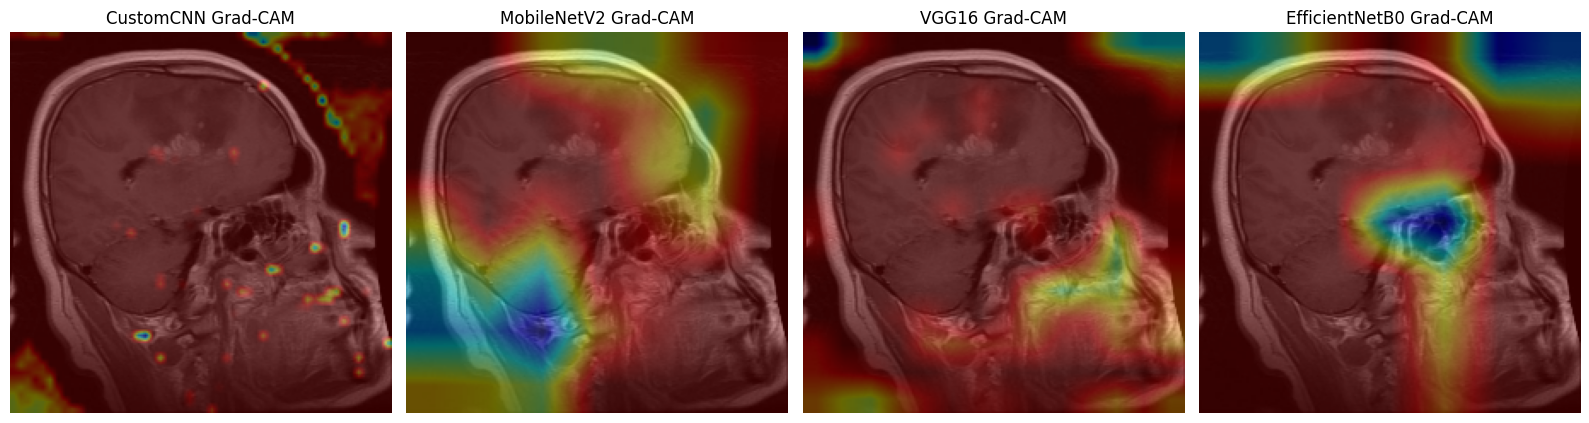

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

# Grad-CAM Function
def generate_grad_cam(model, image, label_index, preprocess=None):
    img_tensor = np.expand_dims(image, axis=0)
    if preprocess:
        img_tensor = preprocess(img_tensor.copy())
    else:
        img_tensor = img_tensor / 255.0

    # Detect last Conv layer
    last_conv_layer = None
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            last_conv_layer = layer.name
            break

    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = predictions[:, label_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(image.astype(np.uint8), 0.6, heatmap_colored, 0.4, 0)
    return superimposed_img

# 🔍 Sample image (1st from validation set)
sample_img = X_val_resized[0]
true_label = y_val[0]

# Define preprocessors
preprocessors = {
    "CustomCNN": None,
    "MobileNetV2": mobilenet_preprocess,
    "VGG16": vgg16_preprocess,
    "EfficientNetB0": efficientnet_preprocess
}

# 🔥 Plot Grad-CAMs
plt.figure(figsize=(16, 8))
for i, (name, model) in enumerate(models.items()):
    grad_cam_img = generate_grad_cam(model, sample_img, true_label, preprocessors[name])
    plt.subplot(1, 4, i+1)
    plt.imshow(grad_cam_img)
    plt.title(f"{name} Grad-CAM")
    plt.axis('off')

plt.tight_layout()
plt.show()



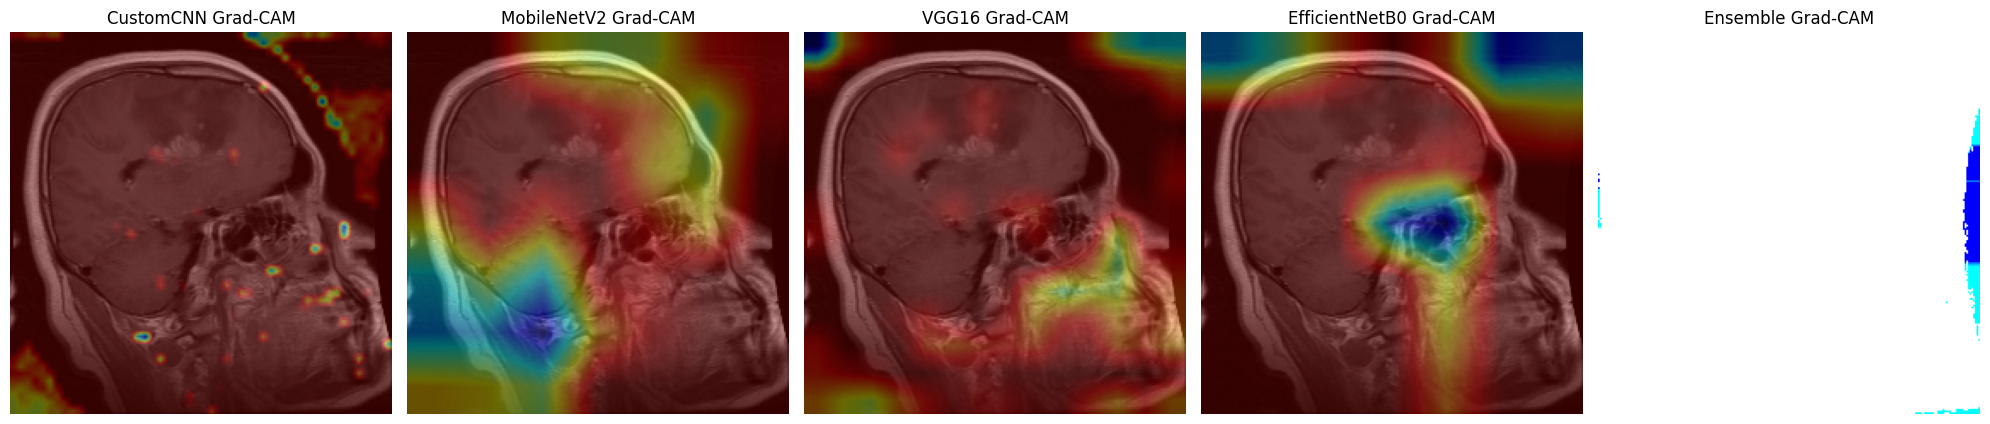

In [17]:
# Define preprocessors
preprocessors = {
    "CustomCNN": None,
    "MobileNetV2": mobilenet_preprocess,
    "VGG16": vgg16_preprocess,
    "EfficientNetB0": efficientnet_preprocess,
    "Ensemble": efficientnet_preprocess  # Ensemble uses EfficientNetB0 preprocessing
}

# 🔥 Plot Grad-CAMs including Ensemble
plt.figure(figsize=(20, 8))  # Adjusted figure size for 5 subplots
for i, (name, model) in enumerate(models.items()):
    grad_cam_img = generate_grad_cam(model, sample_img, true_label, preprocessors[name])
    plt.subplot(1, 5, i+1)
    plt.imshow(grad_cam_img)
    plt.title(f"{name} Grad-CAM")
    plt.axis('off')

# Add Ensemble Grad-CAM by averaging individual model contributions
ensemble_grads = np.mean([generate_grad_cam(model, sample_img, true_label, preprocessors[name])[:, :, ::-1] 
                         for name, model in models.items()], axis=0)  # Convert BGR to RGB
plt.subplot(1, 5, 5)
plt.imshow(ensemble_grads)
plt.title("Ensemble Grad-CAM")
plt.axis('off')

plt.tight_layout()
plt.show()

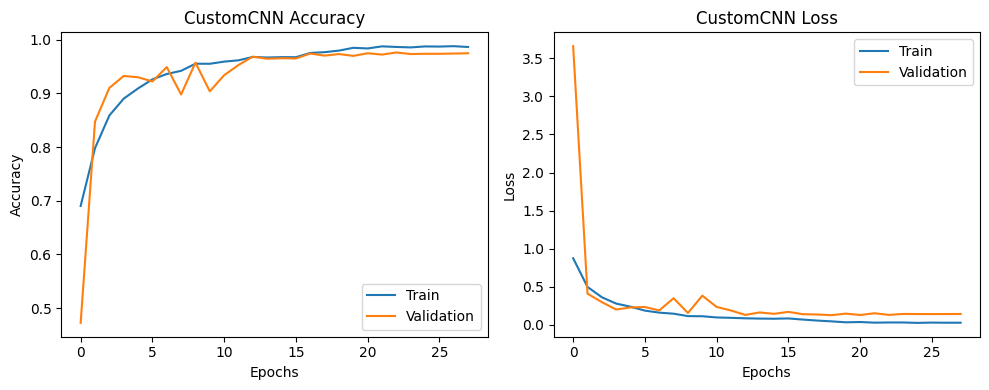

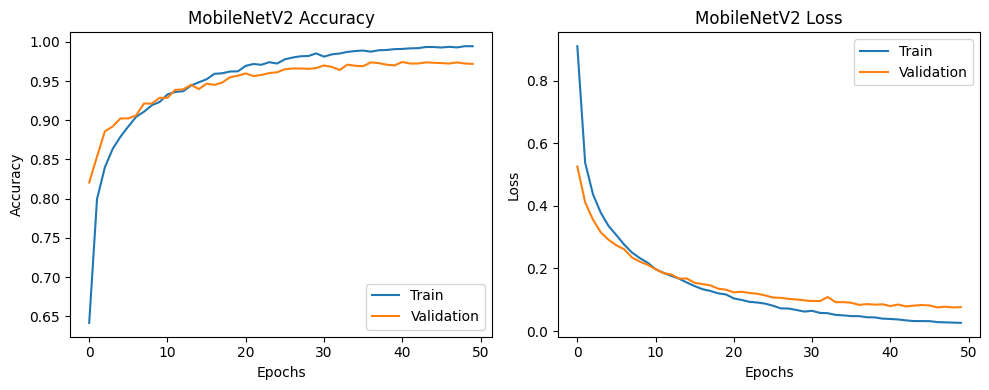

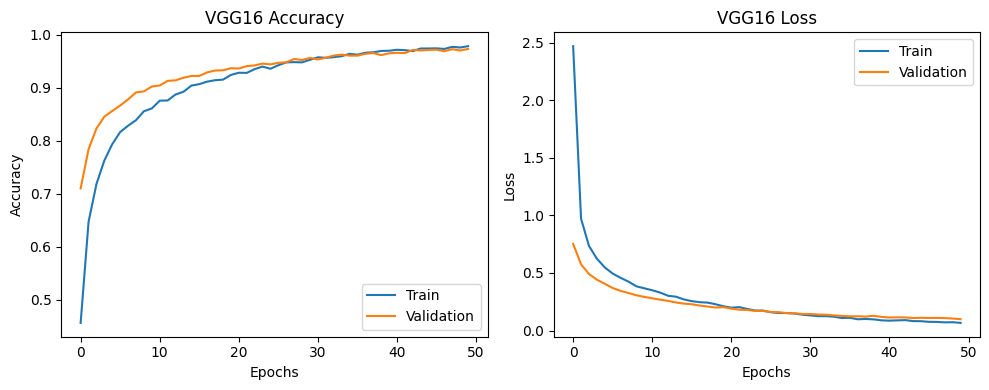

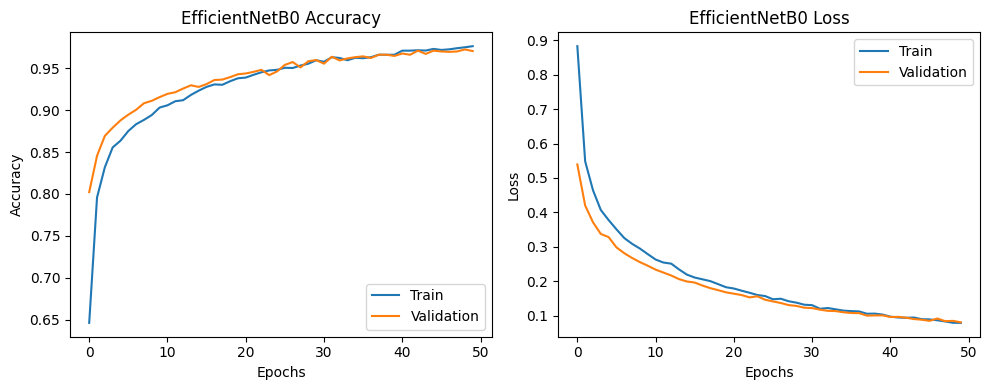

In [18]:
# ✅ Step 12: Accuracy and Loss Curves
for name, history in histories.items():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(f'{name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()

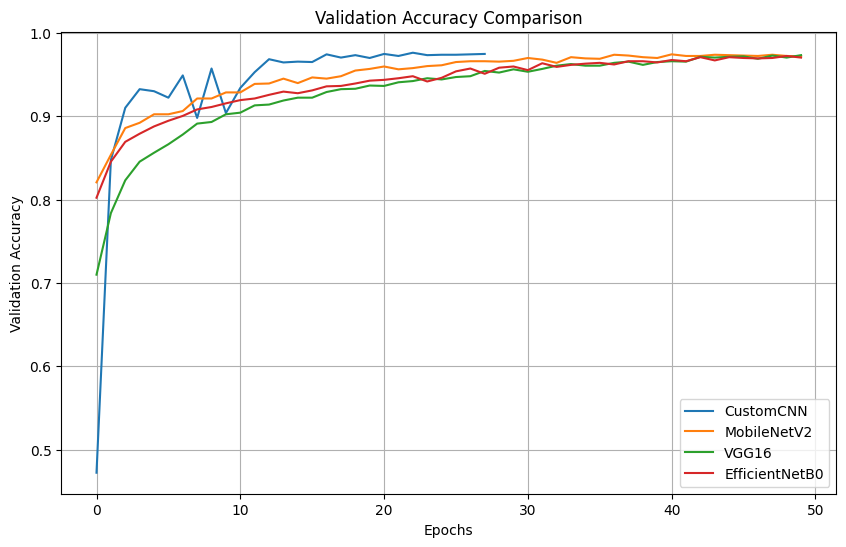

In [19]:
# ✅ Step 13: Compare Validation Accuracies Across Models
plt.figure(figsize=(10, 6))
for name, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{name}')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


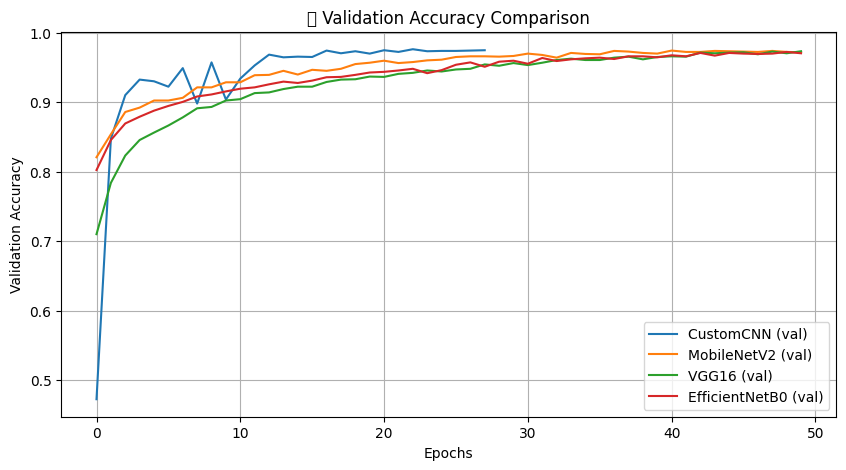

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


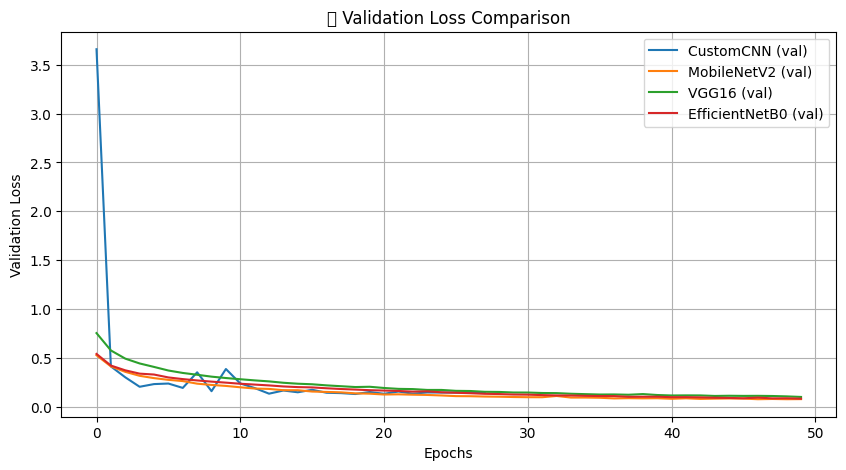

In [20]:
# ✅ Step 12: Combined Accuracy and Loss Curves for All Models

# Plot all model accuracies on one graph
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label=f'{name} (val)')
plt.title('📈 Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot all model losses on one graph
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label=f'{name} (val)')
plt.title('📉 Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


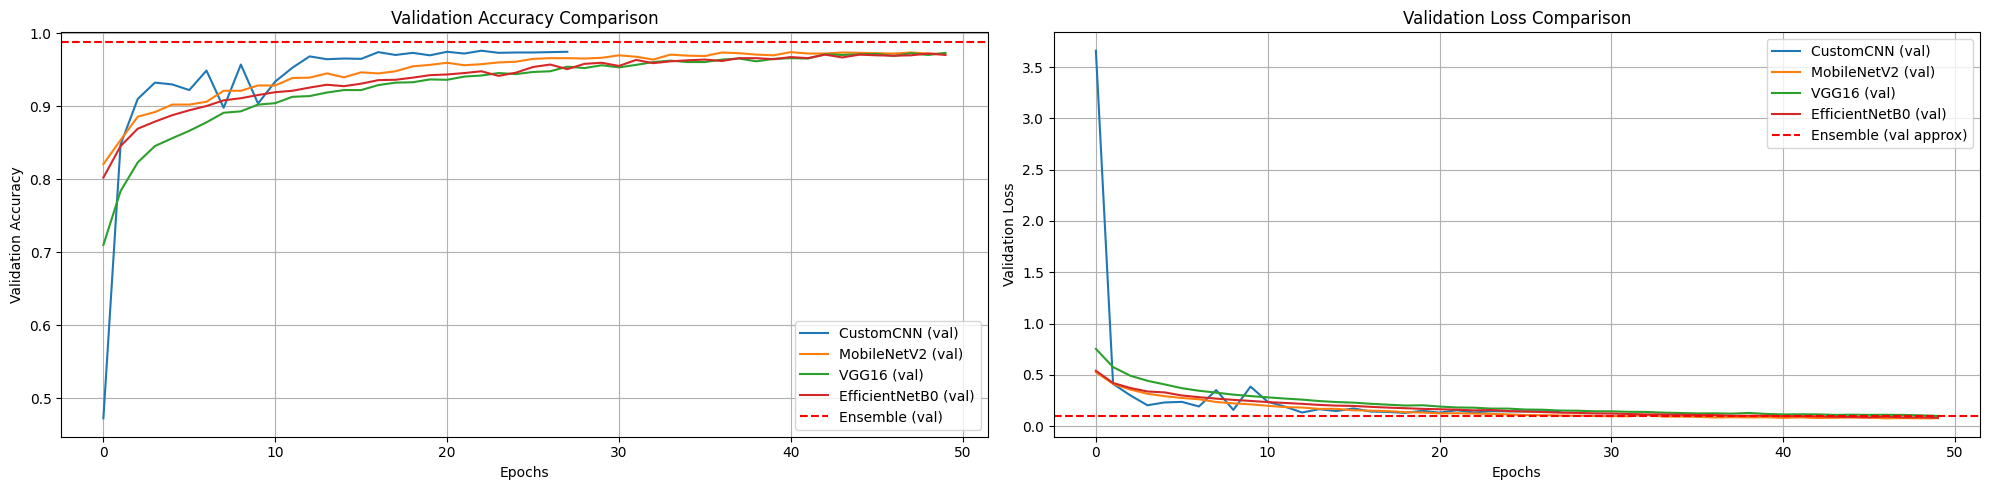

In [21]:
# ✅ Step 12: Combined Accuracy and Loss Curves for All Models

# Create a figure with two subplots side by side
plt.figure(figsize=(20, 5))

# Plot all model validation accuracies on the left subplot
plt.subplot(1, 2, 1)
for name, history in histories.items():
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label=f'{name} (val)')
# Add ensemble validation accuracy (using Step 8 ensemble_acc as a proxy, adjust if ensemble history exists)
plt.axhline(y=ensemble_acc, color='r', linestyle='--', label='Ensemble (val)')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot all model validation losses on the right subplot
plt.subplot(1, 2, 2)
for name, history in histories.items():
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label=f'{name} (val)')
# Add ensemble validation loss (placeholder; replace with ensemble history if available)
plt.axhline(y=np.mean([history.history['val_loss'][-1] for history in histories.values() if 'val_loss' in history.history]), 
            color='r', linestyle='--', label='Ensemble (val approx)')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

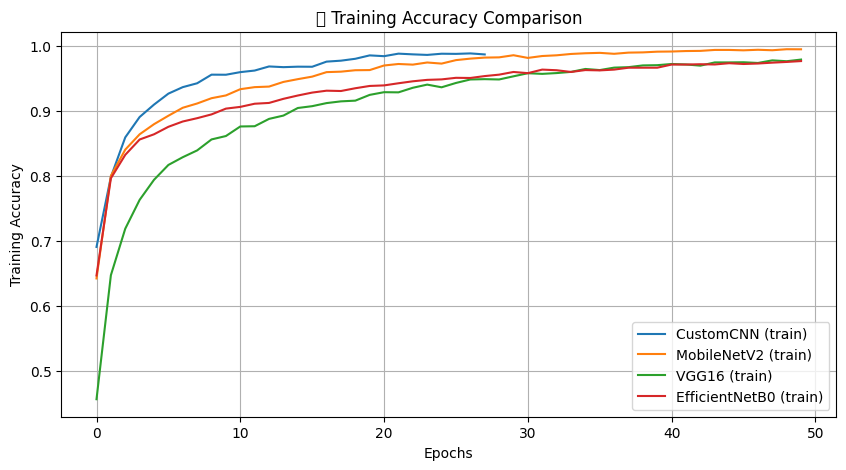

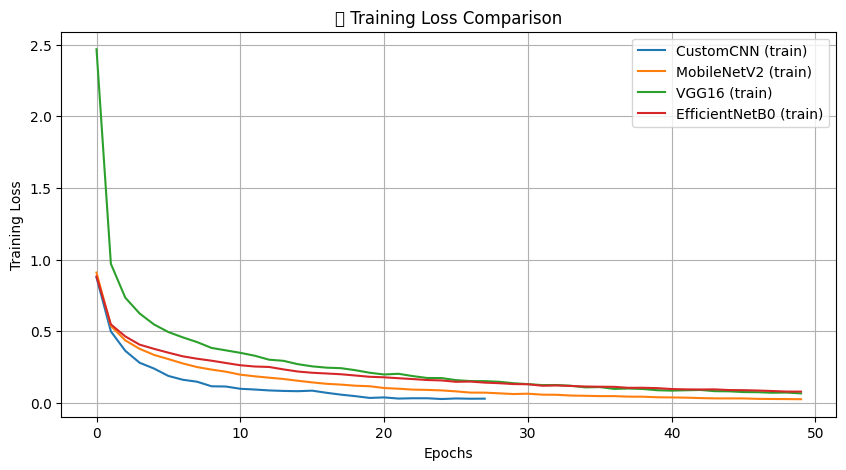

In [22]:
# ✅ Step 12: Combined Training Accuracy and Loss for All Models

# Plot all model training accuracies on one graph
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label=f'{name} (train)')
plt.title('📈 Training Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot all model training losses on one graph
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label=f'{name} (train)')
plt.title('📉 Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()


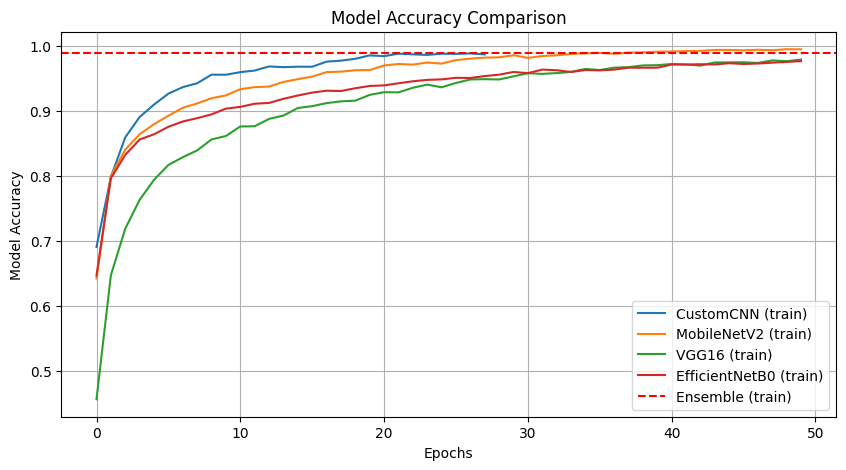

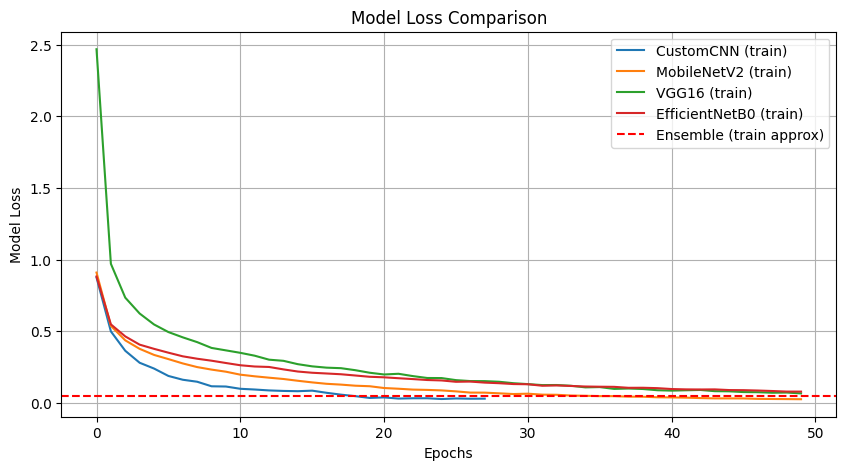

In [23]:
# ✅ Step 12: Combined Training Accuracy and Loss for All Models

# Plot all model training accuracies on one graph
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label=f'{name} (train)')
# Add ensemble accuracy (using Step 8 ensemble_acc as a proxy, adjust if ensemble history exists)
plt.axhline(y=ensemble_acc, color='r', linestyle='--', label='Ensemble (train)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot all model training losses on one graph
plt.figure(figsize=(10, 5))
for name, history in histories.items():
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label=f'{name} (train)')
# Add ensemble loss (placeholder; replace with ensemble history if available)
plt.axhline(y=np.mean([history.history['loss'][-1] for history in histories.values() if 'loss' in history.history]), 
            color='r', linestyle='--', label='Ensemble (train approx)')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.legend()
plt.grid(True)
plt.show()

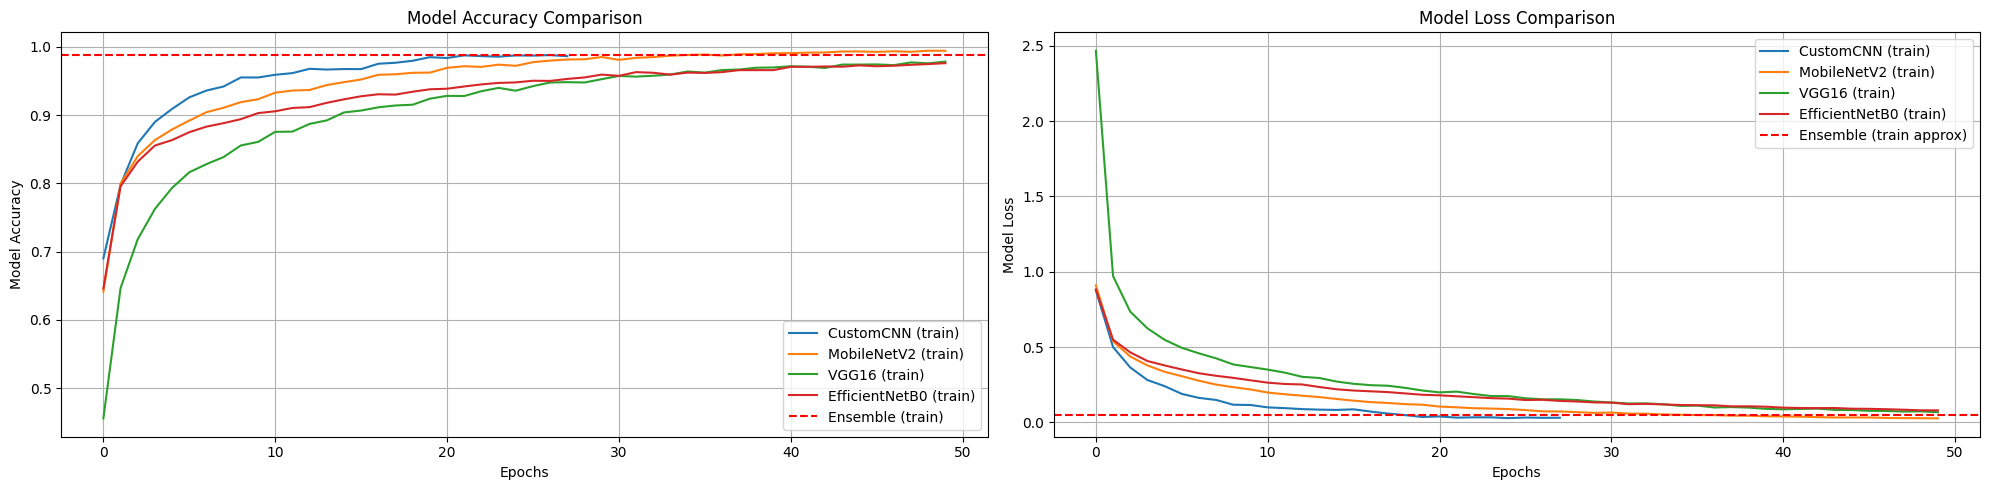

In [24]:
# ✅ Step 12: Combined Training Accuracy and Loss for All Models

# Create a figure with two subplots side by side
plt.figure(figsize=(20, 5))

# Plot all model training accuracies on the left subplot
plt.subplot(1, 2, 1)
for name, history in histories.items():
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label=f'{name} (train)')
# Add ensemble accuracy (using Step 8 ensemble_acc as a proxy, adjust if ensemble history exists)
plt.axhline(y=ensemble_acc, color='r', linestyle='--', label='Ensemble (train)')
plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Model Accuracy')
plt.legend()
plt.grid(True)

# Plot all model training losses on the right subplot
plt.subplot(1, 2, 2)
for name, history in histories.items():
    if 'loss' in history.history:
        plt.plot(history.history['loss'], label=f'{name} (train)')
# Add ensemble loss (placeholder; replace with ensemble history if available)
plt.axhline(y=np.mean([history.history['loss'][-1] for history in histories.values() if 'loss' in history.history]), 
            color='r', linestyle='--', label='Ensemble (train approx)')
plt.title('Model Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Model Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

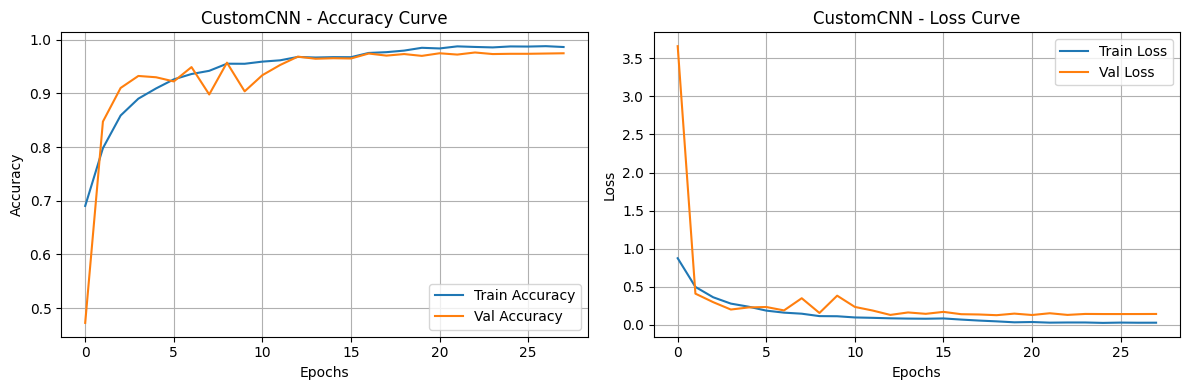

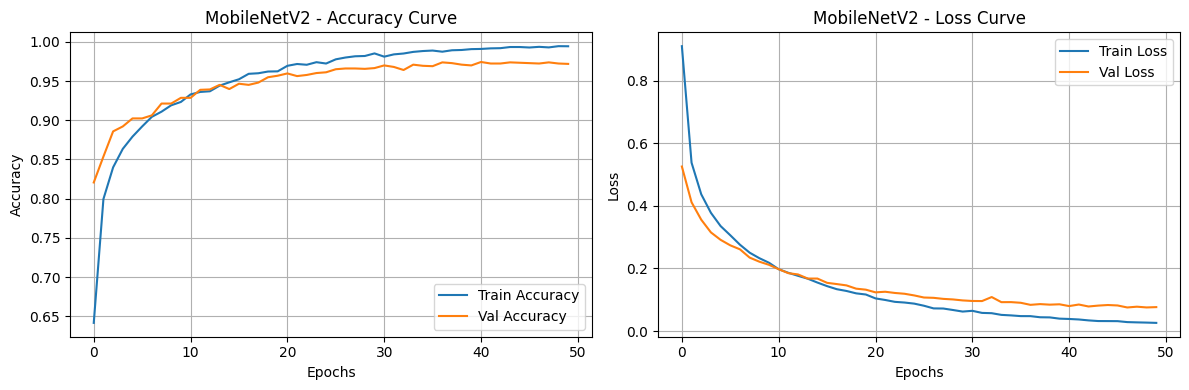

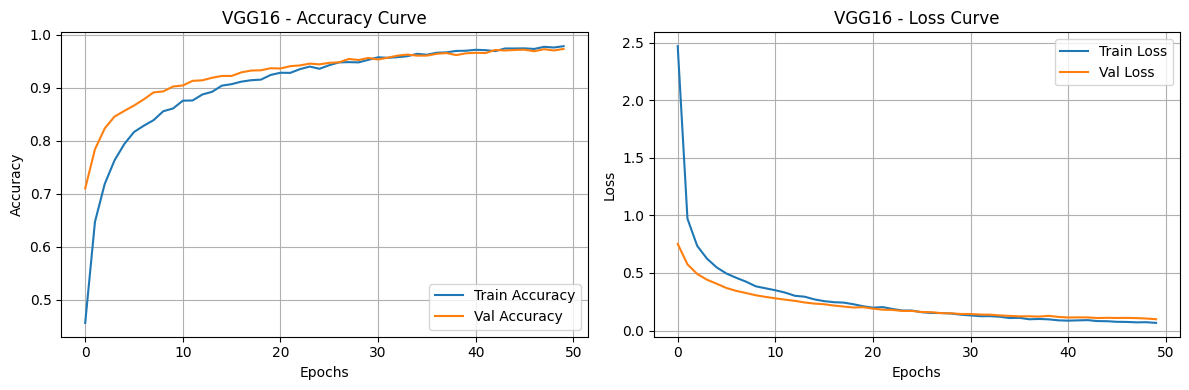

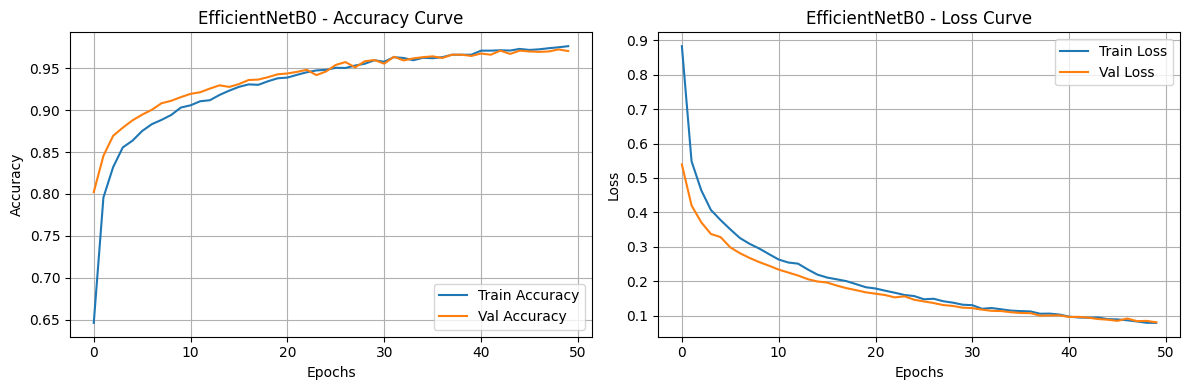

In [25]:
# ✅ Step 14: Accuracy/Loss Curves (Train vs Validation)
for name, history in histories.items():
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    if acc and val_acc:
        plt.figure(figsize=(12, 4))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(acc, label='Train Accuracy')
        plt.plot(val_acc, label='Val Accuracy')
        plt.title(f'{name} - Accuracy Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(loss, label='Train Loss')
        plt.plot(val_loss, label='Val Loss')
        plt.title(f'{name} - Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score

# ✅ Step 15: Model Performance Comparison Table
metrics_table = []

for name, preds in model_preds.items():
    y_pred_labels = np.argmax(preds, axis=1)
    acc = accuracy_score(y_val, y_pred_labels)
    prec = precision_score(y_val, y_pred_labels, average='macro')
    rec = recall_score(y_val, y_pred_labels, average='macro')
    f1 = f1_score(y_val, y_pred_labels, average='macro')
    metrics_table.append([name, acc, prec, rec, f1])

# Add Ensemble
ensemble_preds = np.argmax(np.mean(list(model_preds.values()), axis=0), axis=1)
ensemble_acc = accuracy_score(y_val, ensemble_preds)
ensemble_prec = precision_score(y_val, ensemble_preds, average='macro')
ensemble_rec = recall_score(y_val, ensemble_preds, average='macro')
ensemble_f1 = f1_score(y_val, ensemble_preds, average='macro')
metrics_table.append(["Ensemble", ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1])

# Create DataFrame
df_metrics = pd.DataFrame(metrics_table, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
df_metrics = df_metrics.sort_values("Accuracy", ascending=False)
print(df_metrics)


            Model  Accuracy  Precision    Recall  F1-Score
4        Ensemble  0.987852   0.987888  0.987794  0.987748
0       CustomCNN  0.973275   0.973676  0.973087  0.972945
2           VGG16  0.973275   0.973691  0.973278  0.973255
1     MobileNetV2  0.972303   0.972132  0.972293  0.972189
3  EfficientNetB0  0.970360   0.970373  0.970314  0.970236


/tmp/ipykernel_19/1180042035.py:9: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


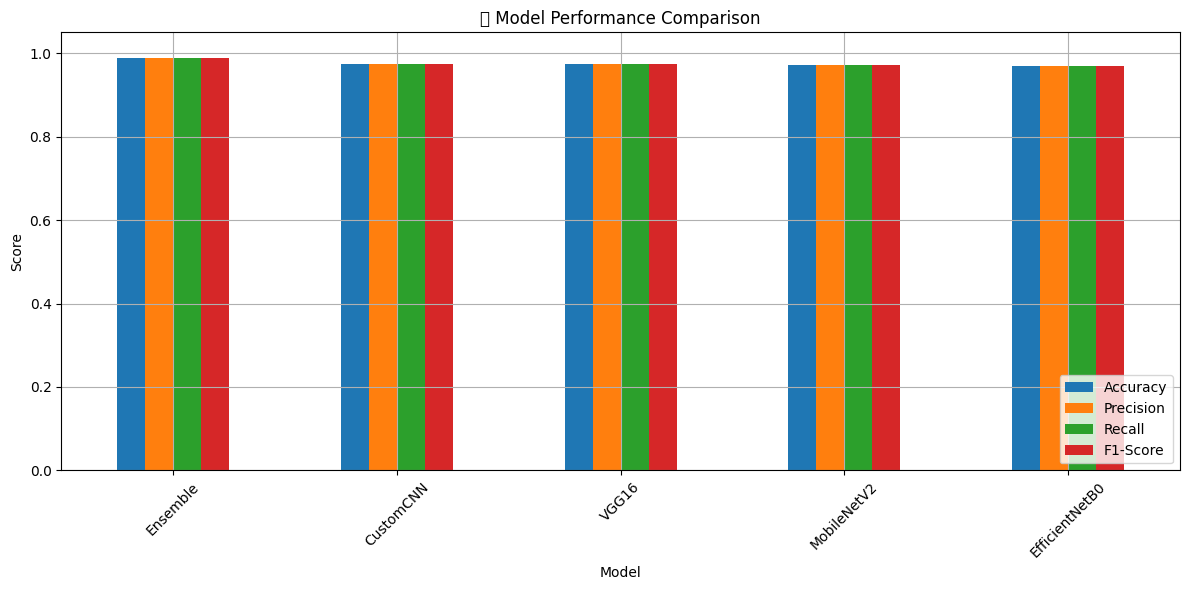

In [27]:
# Optional: Visual Comparison
df_metrics.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-Score"]].plot(kind="bar", figsize=(12, 6))
plt.title("📊 Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
